In [1544]:
import pandas as pd
from glob import glob
import tushare as ts
from copy import deepcopy
from os.path import abspath,dirname,join
pd.set_option('display.max_rows', 300*2)

#### 计算持仓时间中位数 /天

In [1800]:
def load_df():
    file_list = glob(join(base_dir,'history_data','*.pkl'))
    file_path = sorted(file_list)[-1]
    df = pd.read_pickle(file_path)
    df['date'] = df.date.astype('datetime64')
    df.sort_values(['symbol', 'date'], inplace=True, ignore_index=True)
    gains = pd.read_pickle(join(base_dir,'results','god.pkl'))
    gains = gains.loc[gains.gains.notna()]
    return df,gains

def get_sell_cw(item, cw):
    sell_cw = item['sell_cw']
    if item['sell_cw'] > cw:
        sell_cw = cw
    return sell_cw


def sub_profits(loss_point, loss_A_copy, loss_B_copy, profits, cw, benjin, sell_count):
    if cw < -0.0001 or cw == 0:
        return cw, profits, sell_count,benjin
    if loss_point <= loss_A_copy['point'] and not loss_A_copy.get("repeat"):
        sell_cw = get_sell_cw(loss_A_copy, cw)
        profits += benjin*cw * sell_cw * loss_A_copy['point']
        benjin += profits
        cw -= sell_cw
        loss_A_copy['repeat'] = True
        sell_count += 1
    elif loss_point <= loss_B_copy['point'] and not loss_B_copy.get("repeat"):
        sell_cw = get_sell_cw(loss_B_copy, cw)
        profits += benjin*cw * sell_cw * loss_B_copy['point']
        benjin += profits
        cw -= sell_cw
        loss_B_copy['repeat'] = True
        sell_count += 1
    return cw, profits, sell_count,benjin


def is_rising_trend(prices, row):
    '''
    判断买入后两天内是否为上升趋势，如果是，加仓
    :param prices:
    :param row:
    :return:
    '''
    day1 = prices.high.iloc[0]
    day2 = prices.high.iloc[1]
    w1 = day1 > row.buy_price
    w2 = day2 > row.buy_price
    return all([w1, w2])

def trading(prices, row, benjin, sell_count, profits, cw, end_date):
    # 判断是否加仓
    point_pool = deepcopy(point_config)
    loss_A_copy = deepcopy(loss_A)
    loss_B_copy = deepcopy(loss_B)
    for ix, price in enumerate(prices.itertuples(), start=1):

        loss_point = (price.low / row.buy_price) - 1
        gains_point = (price.high / row.buy_price) - 1
#         if ix > 3 and gains_point <= 0.01:
#             end_date = price.date
#             break

        if cw < -0.0001 or cw == 0:
            end_date = price.date
            break
        if price.high >= row.G3:
            end_date = price.date
            break

        # 如果仓位小于0 结束操作
        for point_item in point_pool:
            if point_item['point'] <= gains_point and not point_item.get("repeat") and not (cw < -0.0001 or cw == 0):
                # 如果卖出仓位大于剩余仓位，则全部卖出
                sell_cw = get_sell_cw(point_item, cw)
                profits += benjin*cw * point_item['point'] * sell_cw
                benjin += profits
                point_item['repeat'] = True
                cw -= sell_cw
                end_date = price.date
                sell_count += 1
        cw, profits, sell_count,benjin = sub_profits(loss_point, loss_A_copy, loss_B_copy, profits, cw, benjin, sell_count)

    return cw, sell_count, profits, end_date


def get_profits(value, benjin=None):
    profits = 0
    sell_count = 0
    use_day = 0
    for ix, row in value.iterrows():
        # 仓位
        cw = 1
        sell_day = sell_interval[row._type]
        prices = df.loc[(df.name == row.stock_name) & (df.date > row.buy_date)].sort_values('date').iloc[:sell_day]
        end_date = prices.date.max()
        cw, sell_count, profits, end_date = trading(prices, row, benjin, sell_count, profits, cw, end_date)
        # if profits / benjin > 0.06:
        #     prices = df.loc[(df.name == row.stock_name) & (df.date > row.buy_date)].sort_values('date').iloc[
        #              sell_day:int(sell_day * 1.6)]
        #     cw, sell_count, profits, end_date = trading(prices, row, benjin, sell_count, profits, cw,
        #                                                          end_date, )
        if cw > 0:
            last_point = (prices.loc[prices.date==end_date,'close'].iloc[0] / row.buy_price) - 1
            profits += (benjin * cw + profits) * last_point * cw
            cw = 0
            end_date = prices.iloc[-1].date
            sell_count += 1
        use_day = (set(pd.date_range(row.buy_date, end_date)) & day).__len__()

    return profits, use_day, sell_count, benjin

def get_interval(st,en):
    return day_list.index(pd.to_datetime(en)) - day_list.index(pd.to_datetime(st))

- 5 万本金
- 按分割点天数循环
- 30% 0.05
- 30%  0.08
- 20% 0.10
- 20% 0.12

#### 利润预测

In [1546]:
base_dir = r"E:\work_dir\workFile\stockProject"
df,gains = load_df()
day = set(df.date)

In [1547]:
day_list = sorted(day)

In [1548]:
show_column = ['stock_name','symbol','start_date','end_date','gains','_type','buy_date','sell_date','buy_price','sell_price','sell_date','G6','G5','G3','G1','G0','close']
gains = gains.loc[gains.gains.notna()]

In [1801]:
point_config = [
    {"name": "point_A", "point": 0.06, 'sell_cw': 0.0},
    {"name": "point_B", "point": 0.15, 'sell_cw': 0.0},
    {"name": "point_C", "point": 0.15, 'sell_cw': 0.0},
    {"name": "point_D", "point": 0.15, 'sell_cw': 0.0},
]
loss_A = {
    "point": -0.03,
    "sell_cw": 0.3
}
loss_B = {
    "point": -0.05,
    "sell_cw": 0.7
}
sell_interval = {"G6": 2, "G5": 3, "G3": 3, "G1": 7, "G0": 20}

In [1802]:
def backtest(_type,_bj):
    # 本金3万
    res = []
    for index,value in gains.query(f"_type == '{_type}'").groupby(
            ['stock_name', 'buy_date']):
        profits, use_day, sell_count,benjin = get_profits(value,_bj)
        res.append([index[0], profits,use_day,value.buy_date.iloc[0],sell_count,benjin])
        print(index[0], profits, use_day, bj, sell_count,benjin)
    df2 = pd.DataFrame(res,columns=['stock','profits','use_day','buy_date','sell_count','benjin'])
    df2['ratio'] = df2.profits / df2['benjin']
    df2['_type'] = _type
    return df2

In [1803]:
res = []
bj = 40000
for _type in [
              #'G0',
              'G1',
              #'G3',
              #'G5',
              #'G6'
             ]:
    res.append(backtest(_type,bj))

GQY视讯 8803.203116897897 8 40000 2 40000
万业企业 2740.2104608683067 8 40000 2 40000
万兴科技 -1331.1799999999998 5 40000 2 40000
万盛股份 1880.8780380900637 8 40000 2 40000
万里马 246.23180940871396 8 40000 3 40000
三变科技 2039.9692040047323 8 40000 2 40000
三孚股份 7748.322925989762 8 40000 2 40000
三鑫医疗 2565.7961981053036 8 40000 2 40000
上海沪工 1959.9587771555882 8 40000 2 40000
世纪天鸿 -1331.1799999999998 7 40000 3 40000
东宝生物 2457.4066244081027 8 40000 2 40000
东方电热 155.91115790249262 8 40000 2 40000
东方银星 449.10360308478676 8 40000 2 40000
东易日盛 2704.073709819346 8 40000 2 40000
东睦股份 7852.95119505287 8 40000 2 40000
东莞控股 347.29854586714805 8 40000 3 40000
东风汽车 2861.973077436033 8 40000 3 40000
中信博 6806.586117894256 8 40000 1 40000
中国铁物 1607.397795328005 8 40000 2 40000
中岩大地 -1331.1799999999998 4 40000 2 40000
中广天择 -1331.1799999999998 4 40000 2 40000
中微公司 2110.8857193675144 8 40000 2 40000
中水渔业 4326.522986519183 8 40000 3 40000
中潜股份 6034.8416067126645 8 40000 5 40000
中环装备 -1331.1799999999998 4 40000 2 40000
中科电气 

In [1804]:
df2 = pd.concat(res)
df2['win'] = df2.profits>0

In [1836]:
((0.035288 * 3)  + 1) ** 12 * 10

33.45188881384268

In [1805]:
df2.loc[df2.profits>0].sort_values('profits')

,stock,profits,use_day,buy_date,sell_count,benjin,ratio,_type,win
352,隆基机械,9.348201,8,2020-05-18,2,40000,0.000234,G1,True
72,北特科技,12.202927,8,2020-04-28,2,40000,0.000305,G1,True
285,联泰环保,32.443620,8,2019-08-07,2,40000,0.000811,G1,True
191,旋极信息,51.157527,8,2020-04-28,2,40000,0.001279,G1,True
150,岭南控股,51.616362,8,2020-10-29,2,40000,0.001290,G1,True
230,海量数据,88.538152,8,2020-09-10,2,40000,0.002213,G1,True
354,雅化集团,127.574518,8,2020-03-17,3,40000,0.003189,G1,True
11,东方电热,155.911158,8,2020-05-21,2,40000,0.003898,G1,True
193,日丰股份,158.058227,8,2020-05-22,2,40000,0.003951,G1,True
229,海达股份,173.624138,8,2020-04-27,2,40000,0.004341,G1,True


In [1822]:
df2.sample(n=3*12).profits.sum() 

40787.28173605872

In [1807]:
df2.loc[df2.profits.idxmin()]

stock                        长春经开
profits                  -1376.63
use_day                         8
buy_date      2020-03-19 00:00:00
sell_count                      2
benjin                      40000
ratio                  -0.0344157
_type                          G1
win                         False
Name: 342, dtype: object

In [1827]:
df2.ratio.describe()

count    367.000000
mean       0.035288
std        0.075183
min       -0.034416
25%       -0.033279
50%        0.014979
75%        0.072458
max        0.291543
Name: ratio, dtype: float64

In [1828]:
df2.profits.describe()

count      367.000000
mean      1411.522188
std       3007.336404
min      -1376.629602
25%      -1331.180000
50%        599.148461
75%       2898.330648
max      11661.728260
Name: profits, dtype: float64

In [1809]:
print(df2.loc[df2.profits>0].profits.mean())
print(df2.loc[df2.profits<0].profits.mean())
print(df2.loc[df2.ratio>0].ratio.mean())
print(df2.loc[df2.ratio<0].ratio.mean())

3216.0930566274474
-1199.0903341108847
0.0804023264156862
-0.029977258352772117


In [1825]:
df2.win.value_counts(normalize=True)

True     0.591281
False    0.408719
Name: win, dtype: float64

In [1811]:
df2.stock.unique().__len__()

351

count    367.000000
mean       0.035288
std        0.075183
min       -0.034416
25%       -0.033279
50%        0.014979
75%        0.072458
max        0.291543
Name: ratio, dtype: float64

In [1813]:
df2.groupby(pd.Grouper(key='buy_date',freq='Y')).profits.mean()

buy_date
2019-12-31    1680.104324
2020-12-31    1474.450814
2021-12-31    1243.422988
Freq: A-DEC, Name: profits, dtype: float64

In [1781]:
abs(df2.loc[df2.profits>0].profits.mean() / df2.loc[df2.profits<0].profits.mean())

2.9324890473925422

In [1814]:
df2.use_day.describe()

count    367.000000
mean       7.065395
std        1.571980
min        2.000000
25%        6.500000
50%        8.000000
75%        8.000000
max        8.000000
Name: use_day, dtype: float64

In [1815]:
df2.profits.describe().astype('int')

count      367
mean      1411
std       3007
min      -1376
25%      -1331
50%        599
75%       2898
max      11661
Name: profits, dtype: int32

In [1590]:
df2.loc[df2.profits<0].profits.mean() / bj

-0.02839098783399072

In [1784]:
df2.loc[df2.profits>0].profits.mean() / bj

0.08501648759543051

In [1785]:
(df2.profits>0).sum() / (df2.profits< 0).sum()

1.2242424242424241

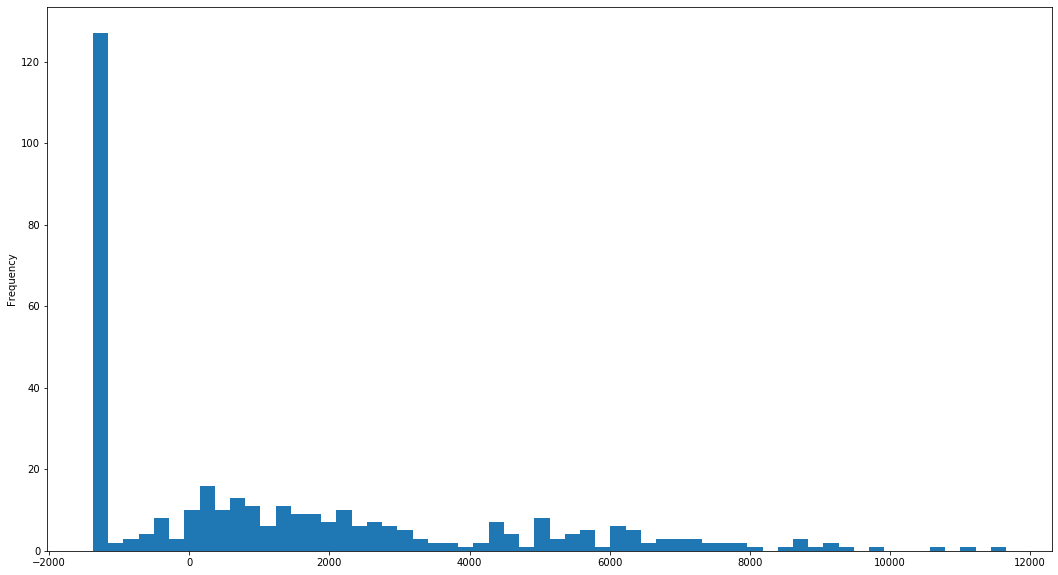

In [1821]:
df2.profits.plot(figsize=(18,10),kind="hist",bins=60)

In [834]:
df2.loc[df2.profits<0]

,stock,profits,use_day,buy_date
2,万兴科技,-1584.728371,5,2021-08-13
4,万里马,-721.405147,11,2020-11-17
19,中岩大地,-1443.217120,4,2021-06-15
20,中广天择,-2024.139618,4,2021-07-26
24,中环装备,-2691.976938,4,2020-04-24
29,中航高科,-1832.066804,3,2021-03-08
33,亚士创能,-801.669608,9,2020-11-17
36,亚联发展,-504.408101,2,2019-11-18
39,伊力特,-1149.577851,4,2021-02-05
41,会稽山,-1915.044971,4,2021-02-04


In [832]:
gains.loc[(gains.gains<=-0.01)&(gains._type=='G1')].sort_values(['buy_date','gains'],ascending=False)[show_column]

,stock_name,symbol,start_date,end_date,gains,_type,buy_date,sell_date,buy_price,sell_price,sell_date,G6,G5,G3,G1,G0,close
2779,洪都航空,600316.SH,2020-11-18,2021-01-07,-0.019146,G1,2021-03-08,2021-03-19,36.990025,36.2818,2021-03-19,50.760049,46.95475,43.149451,36.990025,30.8306,37.10
1903,广信材料,300537.SZ,2020-09-11,2020-10-12,-0.011030,G1,2020-12-11,2020-12-15,18.605220,18.4000,2020-12-15,25.189560,23.37000,21.550440,18.605220,15.6600,15.45
3282,祥和实业,603500.SH,2020-07-28,2020-09-02,-0.056942,G1,2020-09-15,2020-09-17,11.307146,10.6633,2020-09-17,15.226707,14.14355,13.060393,11.307146,9.5539,9.17


In [829]:
13.93 / 14.27

0.9761737911702874

In [822]:
14.4*700

10080.0

In [823]:
24.20*500

12100.0